# Import Libraries

In [1]:
import numpy as np
import pandas as pd
import pickle

import shap


from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
nltk.download('wordnet')

/home/sciencerz/miniconda3/envs/se/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/sciencerz/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/sciencerz/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Data Extraction

In [2]:
raw = pd.read_csv("enron_spam_data.csv")
raw.head()

,Message ID,Subject,Message,Spam/Ham,Date
0,0,christmas tree farm pictures,NaN,ham,1999-12-10
1,1,"vastar resources , inc .","gary , production from the high island larger ...",ham,1999-12-13
2,2,calpine daily gas nomination,- calpine daily gas nomination 1 . doc,ham,1999-12-14
3,3,re : issue,fyi - see note below - already done .\nstella\...,ham,1999-12-14
4,4,meter 7268 nov allocation,fyi .\n- - - - - - - - - - - - - - - - - - - -...,ham,1999-12-14


In [3]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33716 entries, 0 to 33715
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Message ID  33716 non-null  int64 
 1   Subject     33427 non-null  object
 2   Message     33345 non-null  object
 3   Spam/Ham    33716 non-null  object
 4   Date        33716 non-null  object
dtypes: int64(1), object(4)
memory usage: 1.3+ MB


In [4]:
# check for NaN
for cols in raw.columns:
    print(f"{cols} : {sum(raw[cols].isna())}")

Message ID : 0
Subject : 289
Message : 371
Spam/Ham : 0
Date : 0


In [5]:
raw = raw.dropna()
raw.head()

,Message ID,Subject,Message,Spam/Ham,Date
1,1,"vastar resources , inc .","gary , production from the high island larger ...",ham,1999-12-13
2,2,calpine daily gas nomination,- calpine daily gas nomination 1 . doc,ham,1999-12-14
3,3,re : issue,fyi - see note below - already done .\nstella\...,ham,1999-12-14
4,4,meter 7268 nov allocation,fyi .\n- - - - - - - - - - - - - - - - - - - -...,ham,1999-12-14
5,5,mcmullen gas for 11 / 99,"jackie ,\nsince the inlet to 3 river plant is ...",ham,1999-12-14


In [6]:
df = raw[["Subject","Message","Spam/Ham"]]
df.head()

,Subject,Message,Spam/Ham
1,"vastar resources , inc .","gary , production from the high island larger ...",ham
2,calpine daily gas nomination,- calpine daily gas nomination 1 . doc,ham
3,re : issue,fyi - see note below - already done .\nstella\...,ham
4,meter 7268 nov allocation,fyi .\n- - - - - - - - - - - - - - - - - - - -...,ham
5,mcmullen gas for 11 / 99,"jackie ,\nsince the inlet to 3 river plant is ...",ham


# Preprocessing

In [7]:
# Categories the Spam/Ham col
df['Category'] = df['Spam/Ham'].apply(lambda x:1 if x=='ham' else 0) #spam:0 ham:1
df = df.drop("Spam/Ham",axis=1)
df.head()

/tmp/ipykernel_5583/2891216812.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Category'] = df['Spam/Ham'].apply(lambda x:1 if x=='ham' else 0) #spam:0 ham:1


,Subject,Message,Category
1,"vastar resources , inc .","gary , production from the high island larger ...",1
2,calpine daily gas nomination,- calpine daily gas nomination 1 . doc,1
3,re : issue,fyi - see note below - already done .\nstella\...,1
4,meter 7268 nov allocation,fyi .\n- - - - - - - - - - - - - - - - - - - -...,1
5,mcmullen gas for 11 / 99,"jackie ,\nsince the inlet to 3 river plant is ...",1


In [8]:
# Combine subject and message col
df['Email'] = df["Subject"]+" "+df["Message"]
df['Original'] = df["Subject"]+" "+df["Message"] 
df = df.drop("Message",axis=1)
df = df.drop("Subject",axis=1)
df.head()

,Category,Email,Original
1,1,"vastar resources , inc . gary , production fro...","vastar resources , inc . gary , production fro..."
2,1,calpine daily gas nomination - calpine daily g...,calpine daily gas nomination - calpine daily g...
3,1,re : issue fyi - see note below - already done...,re : issue fyi - see note below - already done...
4,1,meter 7268 nov allocation fyi .\n- - - - - - -...,meter 7268 nov allocation fyi .\n- - - - - - -...
5,1,"mcmullen gas for 11 / 99 jackie ,\nsince the i...","mcmullen gas for 11 / 99 jackie ,\nsince the i..."


In [9]:
#lower casing
df['Email'] = df['Email'].str.lower()
df.head()

,Category,Email,Original
1,1,"vastar resources , inc . gary , production fro...","vastar resources , inc . gary , production fro..."
2,1,calpine daily gas nomination - calpine daily g...,calpine daily gas nomination - calpine daily g...
3,1,re : issue fyi - see note below - already done...,re : issue fyi - see note below - already done...
4,1,meter 7268 nov allocation fyi .\n- - - - - - -...,meter 7268 nov allocation fyi .\n- - - - - - -...
5,1,"mcmullen gas for 11 / 99 jackie ,\nsince the i...","mcmullen gas for 11 / 99 jackie ,\nsince the i..."


In [10]:
# remove punctuation
df['Email'] = df['Email'].str.replace(r'[^\w\s]', '', regex=True)
df.head()

,Category,Email,Original
1,1,vastar resources inc gary production from t...,"vastar resources , inc . gary , production fro..."
2,1,calpine daily gas nomination calpine daily ga...,calpine daily gas nomination - calpine daily g...
3,1,re issue fyi see note below already done \n...,re : issue fyi - see note below - already done...
4,1,meter 7268 nov allocation fyi \n ...,meter 7268 nov allocation fyi .\n- - - - - - -...
5,1,mcmullen gas for 11 99 jackie \nsince the inl...,"mcmullen gas for 11 / 99 jackie ,\nsince the i..."


In [11]:
# remove non-alphabetic characters
df['Email'] = df['Email'].str.replace(r'[^a-zA-Z\s]', '', regex=True)
df.head()

,Category,Email,Original
1,1,vastar resources inc gary production from t...,"vastar resources , inc . gary , production fro..."
2,1,calpine daily gas nomination calpine daily ga...,calpine daily gas nomination - calpine daily g...
3,1,re issue fyi see note below already done \n...,re : issue fyi - see note below - already done...
4,1,meter nov allocation fyi \n ...,meter 7268 nov allocation fyi .\n- - - - - - -...
5,1,mcmullen gas for jackie \nsince the inlet t...,"mcmullen gas for 11 / 99 jackie ,\nsince the i..."


In [12]:
# remove stop words
df['Email'] = df['Email'].str.split()
df['Email'] = df['Email'].apply(lambda x: [word for word in x if word not in stop_words])
df.head()

,Category,Email,Original
1,1,"[vastar, resources, inc, gary, production, hig...","vastar resources , inc . gary , production fro..."
2,1,"[calpine, daily, gas, nomination, calpine, dai...",calpine daily gas nomination - calpine daily g...
3,1,"[issue, fyi, see, note, already, done, stella,...",re : issue fyi - see note below - already done...
4,1,"[meter, nov, allocation, fyi, forwarded, lauri...",meter 7268 nov allocation fyi .\n- - - - - - -...
5,1,"[mcmullen, gas, jackie, since, inlet, river, p...","mcmullen gas for 11 / 99 jackie ,\nsince the i..."


In [13]:
# Lemmatization
lemmatizer = WordNetLemmatizer()
df['Email'] = df['Email'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])
df.head()

,Category,Email,Original
1,1,"[vastar, resource, inc, gary, production, high...","vastar resources , inc . gary , production fro..."
2,1,"[calpine, daily, gas, nomination, calpine, dai...",calpine daily gas nomination - calpine daily g...
3,1,"[issue, fyi, see, note, already, done, stella,...",re : issue fyi - see note below - already done...
4,1,"[meter, nov, allocation, fyi, forwarded, lauri...",meter 7268 nov allocation fyi .\n- - - - - - -...
5,1,"[mcmullen, gas, jackie, since, inlet, river, p...","mcmullen gas for 11 / 99 jackie ,\nsince the i..."


In [14]:
# rejoin words into sentance
df['Email'] = df['Email'].apply(lambda x: ' '.join(x))
df.head()

,Category,Email,Original
1,1,vastar resource inc gary production high islan...,"vastar resources , inc . gary , production fro..."
2,1,calpine daily gas nomination calpine daily gas...,calpine daily gas nomination - calpine daily g...
3,1,issue fyi see note already done stella forward...,re : issue fyi - see note below - already done...
4,1,meter nov allocation fyi forwarded lauri allen...,meter 7268 nov allocation fyi .\n- - - - - - -...
5,1,mcmullen gas jackie since inlet river plant sh...,"mcmullen gas for 11 / 99 jackie ,\nsince the i..."


In [15]:
#Vectorize
vectorizer = TfidfVectorizer(min_df = 10)
X = vectorizer.fit_transform(df["Email"])

In [16]:
y = df.iloc[:]

In [17]:
# check is balanced
y["Category"].value_counts() # it is

Category
0    16614
1    16493
Name: count, dtype: int64

# Model Training

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [19]:
model = RandomForestClassifier(n_estimators=10)

y_train_cat = y_train["Category"]
y_test_cat = y_test["Category"]

# Train model
model.fit(X_train, y_train_cat)

# Make predictions
y_pred = model.predict(X_test)

# Measure metrics
accuracy = accuracy_score(y_test_cat, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print(classification_report(y_test_cat, y_pred))

print(accuracy) 

# Store Model wieghts
model_filename = f"enron_spam.pkl"
with open(model_filename, 'wb') as file:
    pickle.dump(model, file)
print(f"Classifier saved as {model_filename}\n\n")

Accuracy: 0.98
              precision    recall  f1-score   support

           0       0.96      0.99      0.98      4134
           1       0.99      0.96      0.97      4143

    accuracy                           0.98      8277
   macro avg       0.98      0.98      0.98      8277
weighted avg       0.98      0.98      0.98      8277

0.9752325721879909
Classifier saved as enron_spam.pkl




# Train Explainer

In [20]:
feature_names = vectorizer.get_feature_names_out()
explainer = shap.Explainer(model, X_train.toarray(), feature_names=feature_names)

# Inference

In [21]:
shap_values = explainer(X_test[:1000].toarray())

 98%|===================| 1970/2000 [00:24<00:00]        

# Visualisation

In [22]:
ind = 5

In [23]:
y_test.iloc[ind]

Category                                                    0
Email       happy new year attn sir got know foreign trade...
Original    happy new year attn : sir ,\ni got to know you...
Name: 15793, dtype: object

In [24]:
email = y_test["Original"].iloc[ind]
print(email, "ham" if y_test["Category"].iloc[ind].item() else "spam" ,sep='\n\n')

happy new year attn : sir ,
i got to know you through our foreign trade office in london , on my search for a reliable partner , during my official trip . i ammr jerry musa chairman - audit committee , with the federal ministry of communication ( fmc ) , i headed the audit panel whose assignment was to audit , review and recommend payment for all contracts awarded by administration . in the course of our review , we discovered that the sum of usd 25 million ( twenty - five million ) was floating in the ministry account .
this money emanated from over - invoicing in the contract awarded to a foreign firm , based on our status as senior government officials in top sensitive position of trust , we cannot stand to claim this money ourselves , hence , i decided to contact you . accordingly , i have consulted and held meetings with some key officials of the federal ministry of finance and central bank of nigeria and we decided to involve a competent partner overseas who could provide facilit

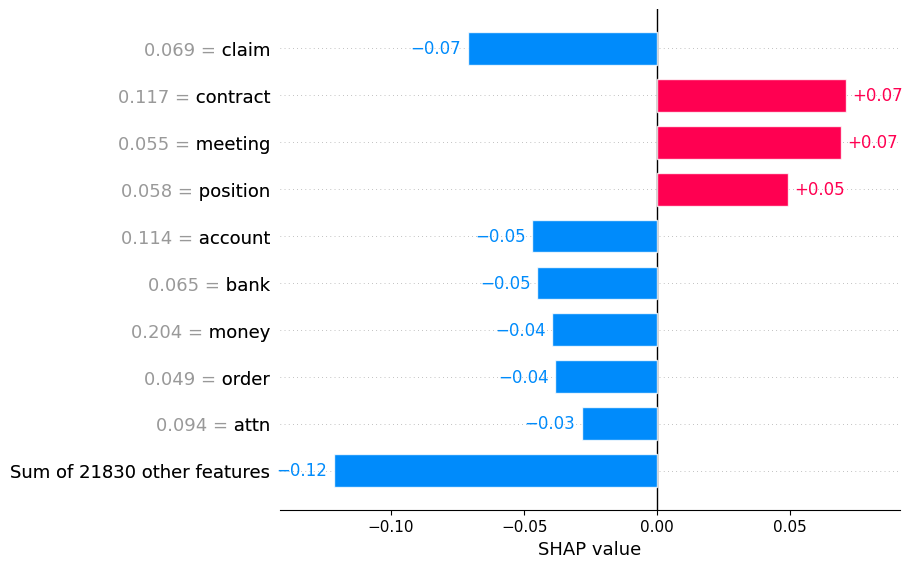

In [25]:
shap.initjs()
shap.plots.bar(shap_values[ind][:,1])

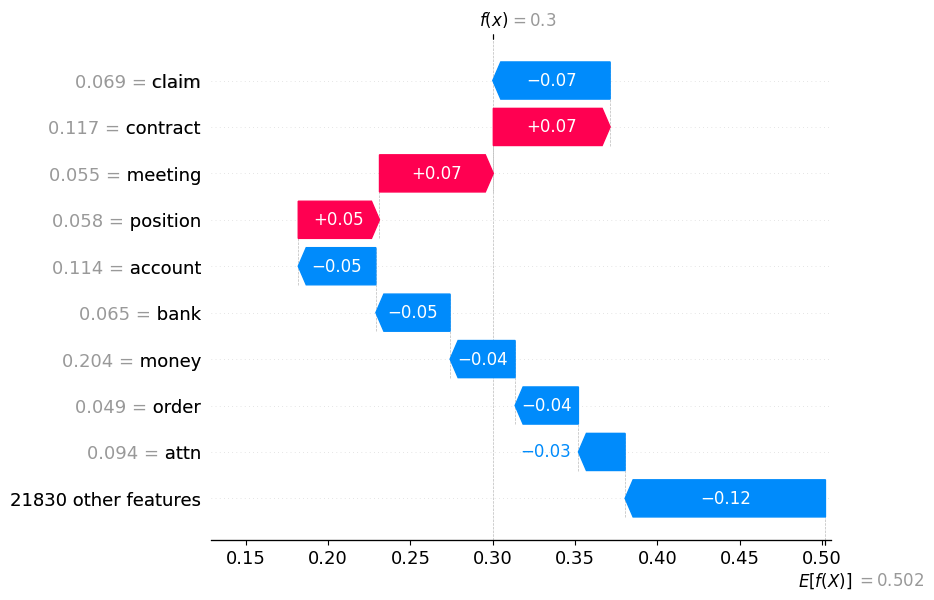

In [26]:
shap.waterfall_plot(shap_values[ind][:,1])

In [27]:
shap_abs = np.abs(shap_values.values)
mean_shap_values = shap_abs.mean(axis=2)[ind,:]
sign = np.argmax(shap_values.argsort.values[ind],axis = 1)

In [28]:
importance_df = pd.DataFrame({"Confidence" : mean_shap_values, "Classification": sign},index=feature_names)

In [29]:
importance_df = importance_df.sort_values(by="Confidence", ascending=False)

In [30]:
importance_df["Confidence"] = importance_df["Confidence"] * importance_df["Classification"].apply(lambda x: 1 if x else -1)
importance_df.head(10)

,Confidence,Classification
claim,-0.071266,0
contract,0.070941,1
meeting,0.069118,1
position,0.049331,1
account,-0.047136,0
bank,-0.045075,0
money,-0.039469,0
order,-0.038439,0
attn,-0.028361,0
know,-0.025236,0


# Pipe into LLM

In [ ]:
import replicate
import os

os.environ["REPLICATE_API_TOKEN"] = "ENTER API TOKEN HERE"

In [32]:
pre_prompt = f"You are a helpfull assistant. You do not respond as 'User' or pretent to be 'User'. You only respond as 'Assistant'.\nYou are an Assistant that helps with explaining Spam and Ham Email classification to a layman,do not use many techinical terms, keep it simple.\nGiven the contents of the email, the classification, and 10 words (each seperated by ###) from the email that contributed most to the decision along with a confidence score from 1 to 10 as to how much it impacted the decision and in which way it did so.\nNegative values indicate that the words contribute to the decision that the email is a spam and Positive values indicate the the corresponding word indicates that it is Ham."

In [33]:
top10 = importance_df['Confidence'].head(10)
top10 = '\n'.join(top10.to_string().split('\n')[1:])

In [34]:
prompt = f"Email: \n{email},\n###\nClassification: {'ham' if y_test['Category'].iloc[ind].item() else 'spam'},\n###\nConfidence Score:\n{top10}"

In [35]:
print(prompt)

Email: 
happy new year attn : sir ,
i got to know you through our foreign trade office in london , on my search for a reliable partner , during my official trip . i ammr jerry musa chairman - audit committee , with the federal ministry of communication ( fmc ) , i headed the audit panel whose assignment was to audit , review and recommend payment for all contracts awarded by administration . in the course of our review , we discovered that the sum of usd 25 million ( twenty - five million ) was floating in the ministry account .
this money emanated from over - invoicing in the contract awarded to a foreign firm , based on our status as senior government officials in top sensitive position of trust , we cannot stand to claim this money ourselves , hence , i decided to contact you . accordingly , i have consulted and held meetings with some key officials of the federal ministry of finance and central bank of nigeria and we decided to involve a competent partner overseas who could provide

In [36]:
input = {
    "prompt": f"{pre_prompt}\n\n\n{prompt} Assistant: ",
    "temperature":0.1,
    "top_p": 0.9,
    "max_length":128,
    "repetition_penalty":1,
}


output = replicate.run(
    f"meta/meta-llama-3-8b-instruct",
    input = input
    )
full_response = ""
for item in output:
    full_response +=item


In [37]:
print(full_response)



Hello! I'd be happy to help you understand how this email was classified as spam.

The email appears to be a scam, and the classification is based on certain words and phrases that are commonly used in spam emails. Here's a breakdown of the 10 words that contributed most to the decision:

* Contract: This word is often used in spam emails to describe a fake business deal or investment opportunity. In this case, the email mentions a "preliminary order" to transfer a large sum of money, which is a red flag.
* Meeting: This word is often used in spam emails to describe a fake meeting or conference call. In this case, the email mentions a meeting with "key officials" of the federal ministry of finance and central bank of nigeria, which is likely a fabrication.
* Position: This word is often used in spam emails to describe a fake job or business opportunity. In this case, the email mentions the sender's position as "chairman - audit committee" of the federal ministry of communication, whi